# Quality Check

<!-- - @author: [Hamid Ali Syed](https://syedha.com)
 -->
- Date: Dec 21, 2022

## Packages:
- pydda is for Dual/Multi-Doppler Analysis
- pyart is for reading and plotting radar data
- wradlib is also a radar toolkit like pyart, and it supports `xarray.dataset` type
- Xarray makes working with labelled `multi-dimensional` arrays in Python simple, efficient, and fun!
- Pandas is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool for working with `tabular` data
- cartopy is used to plot `maps`, `projections` and much more.
 

In [2]:
import warnings
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=RuntimeWarning)
warnings.filterwarnings(action='ignore',category=UserWarning)
import pyart
from collections import Counter
# import pydda
# import wradlib as wrl
# import xarray as xr
# import pandas as pd
import datetime as dt
import numpy as np
import pathlib
import scipy
# import wradlib as wrl
# import netCDF4 as nc
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter, FuncFormatter
from matplotlib import axes
import cartopy.crs as ccrs
import cartopy.feature as feat
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from metpy.plots import USCOUNTIES
import glob, os, sys, re
%matplotlib inline

In [3]:
import urllib.request
url = "https://raw.githubusercontent.com/syedhamidali/test_scripts/master/map_features.py"
urllib.request.urlretrieve(url, "map_features.py")
import map_features as mf

In [4]:
def natural_sort_key(s, _re=re.compile(r'(\d+)')):
    return [int(t) if i & 1 else t.lower() for i, t in enumerate(_re.split(s))]

In [5]:
def align_field(field):
    values, counts = np.unique(field['data'], return_counts=True)
    c_value = values[np.argmax(counts)]
    field['data'] = np.array([c_value])
    return field

def align_radar_coords(radar):
    radar.longitude = align_field(radar.longitude)
    radar.latitude = align_field(radar.latitude)
    radar.altitude = align_field(radar.altitude)
    radar.altitude_agl = align_field(radar.altitude_agl)
    return radar

In [27]:
def filter_radar(radar, vel_field="VEL_F", refl_field="DBZHCC_F", 
                 ncp_field="NCP", rhv_field="RHOHV", phi_field="PHIDP"):
    '''Remove noise based on velocity texture and mask all the fields'''
    # Drop some fields
    fields_to_drop = ["DBMHC", "DBMVC", "VEL", "VS", "VS_F", "VL", "VL_F", "DBZHCC"]
    for field in fields_to_drop:
        if field in radar.fields:
            del radar.fields[field]
        
    texture = pyart.retrieve.calculate_velocity_texture(radar, 
                                                        vel_field=vel_field, 
                                                        wind_size=3, 
                                                        check_nyq_uniform=False)
    radar.add_field('VT',texture,replace_existing=True)
    # create gatefilter
    gf = pyart.filters.GateFilter(radar)
    gf.exclude_invalid(refl_field)
    gf.exclude_outside(refl_field, -20, 100)
#     gf.exclude_below("SNRHC", 10)
    gf.exclude_above('VT', 14)
#     gf_despeckeld = pyart.correct.despeckle_field(radar, vel_field, gatefilter=gf)
#     corr_V = radar.fields[vel_field].copy()
#     V_array = np.ma.masked_where(gf_despeckeld.gate_included == False, radar.fields[vel_field]['data'])
#     corr_V['data'] = V_array
#     radar.add_field('CVEL', corr_V, replace_existing=True)

    gf_despeckeld = pyart.correct.despeckle_field(radar, refl_field, gatefilter=gf)
    corr_ZH = radar.fields[refl_field].copy()
    ZH_array = np.ma.masked_where(gf_despeckeld.gate_included == False, radar.fields[refl_field]['data'])
    corr_ZH['data'] = ZH_array
    radar.add_field('DBZH',corr_ZH,replace_existing=True)
    
    # get the mask
    mask = np.ma.getmask(radar.fields['DBZH']['data'])
    radar.scan_type = b'ppi'
    # iterate through remaining fields
    for field in radar.fields.keys():
        # mask the field
        radar.fields[field]['data'] = np.ma.masked_where(mask, radar.fields[field]['data'])
    return radar

In [28]:
def dealiase(radar, vel_name = "VEL_F"):
    #check to see if radar object has nyquist velocity
    try: 
        gatefilter = pyart.correct.GateFilter(radar)
        corr_vel   = pyart.correct.dealias_region_based(
            radar, vel_field=vel_name, keep_original=False, gatefilter = gatefilter)
        radar.add_field(vel_name, corr_vel, True)
    except:
        None

In [29]:
def qc(radar):
    radar = align_radar_coords(radar)
    radar = filter_radar(radar)
    dealiase(radar)
    return radar

In [30]:
basedir = "/depot/dawson29/data/Projects/PERiLS/obsdata/2022/Illinois_Mobile_Radar/"
iop1 = os.path.join(basedir,"IOP1")

In [31]:
cow1 = os.path.join(iop1, "COW1/merged/")
dow7 = os.path.join(iop1, "DOW7/merged/")
dow8 = os.path.join(iop1, "DOW8/merged/")

In [32]:
cow1_files = sorted(glob.glob(os.path.join(cow1,"*nc")), key=natural_sort_key)
print(f'No. of COW1 files: {len(cow1_files)}')
dow7_files = sorted(glob.glob(os.path.join(dow7,"*nc")), key=natural_sort_key)
print(f'No. of DOW7 files: {len(dow7_files)}')
dow8_files = sorted(glob.glob(os.path.join(dow8,"*nc")), key=natural_sort_key)
print(f'No. of DOW8 files: {len(dow8_files)}')

No. of COW1 files: 181
No. of DOW7 files: 148
No. of DOW8 files: 173


In [33]:
out_dir = "/depot/dawson29/data/Projects/PERiLS/obsdata/2022/Illinois_Mobile_Radar/IOP1/"
radar_type = ["COW1", "DOW7", "DOW8"]

In [34]:
def plot_radar(radar):
    # Let us view the vleocity with the filter applied.
    fig = plt.figure(figsize=[10, 4])
    display = pyart.graph.RadarMapDisplay(radar)
    ax = plt.subplot(121)
    display.plot_ppi("DBZHCC_F", vmin=-10., vmax=70., cmap='pyart_HomeyerRainbow')
    ax = plt.subplot(122)
    display.plot_ppi("VEL_F", sweep=0, cmap="pyart_NWSVel", vmin = -30, vmax = 30,)
    plt.show()

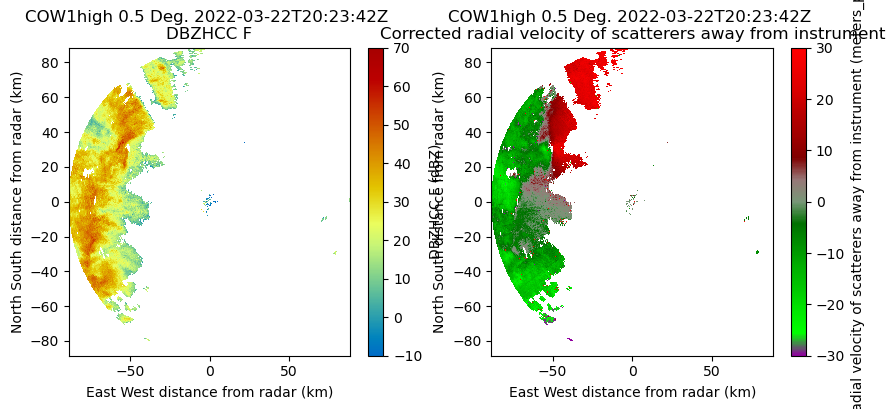

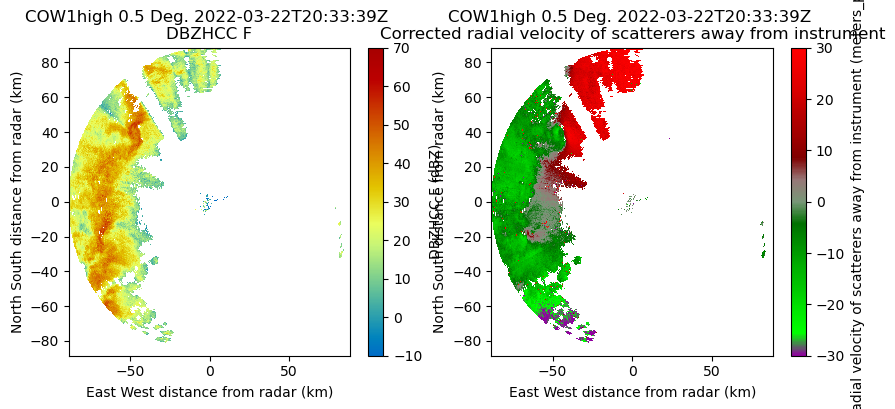

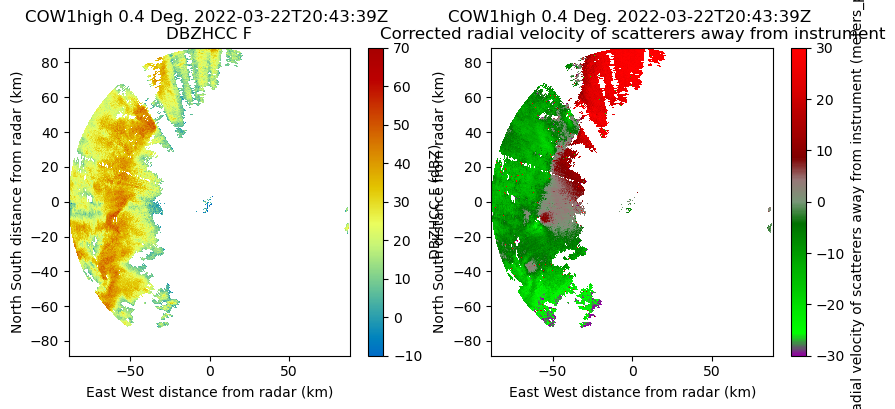

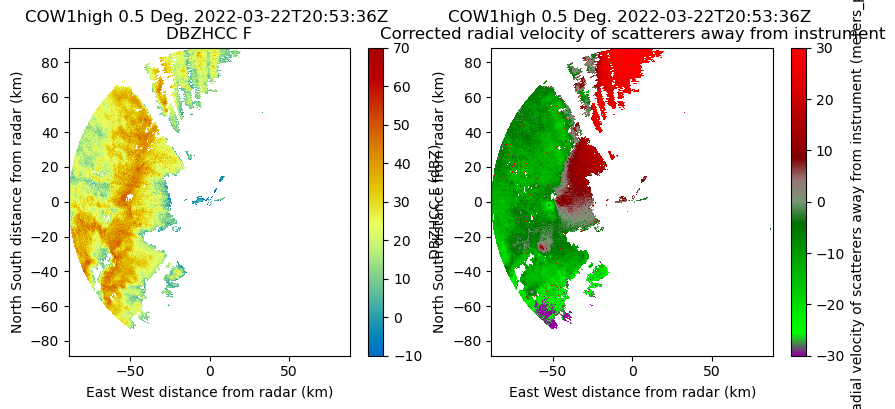

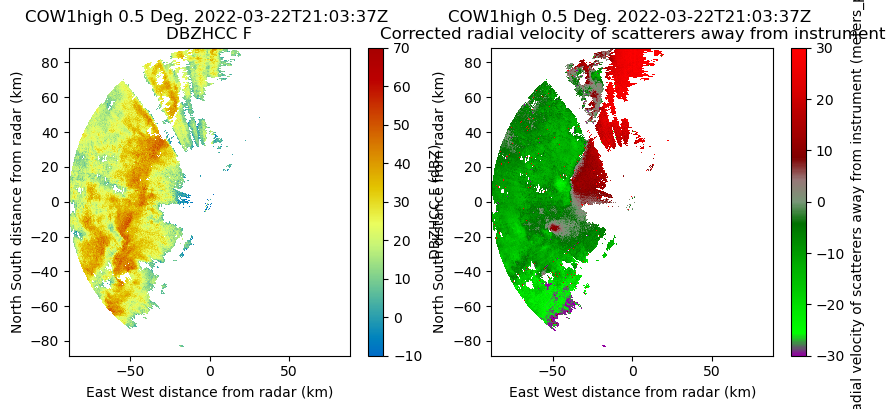

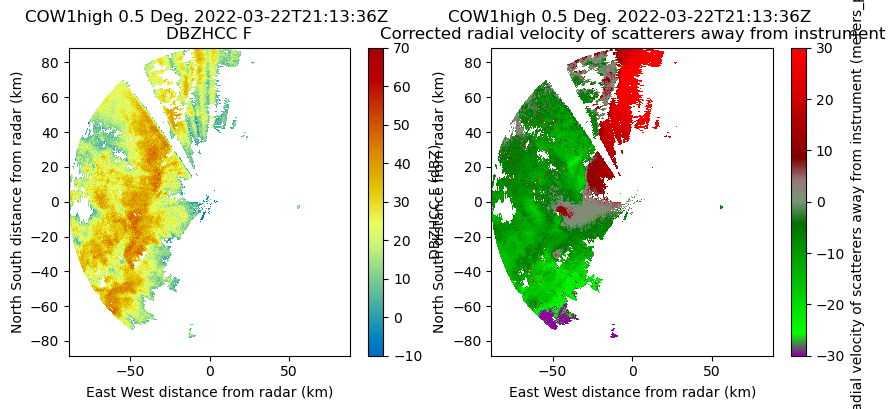

In [35]:
for i in range(100, 126, 5):
    file = cow1_files[i]
    radar = pyart.io.read(file)
    radar = qc(radar)
    plot_radar(radar)
    del radar

In [21]:
# Set the nyquist to what we see in the instrument parameter above.
# Calculate the velocity texture
vel_texture = pyart.retrieve.calculate_velocity_texture(
    radar, vel_field="VEL_F", wind_size=3)
radar.add_field("VT", vel_texture, replace_existing=True)

Text(0, 0.5, 'Count')

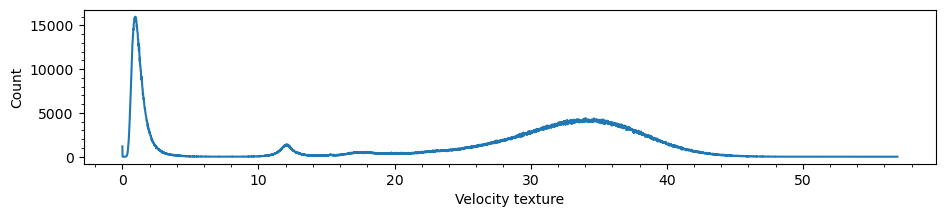

In [22]:
# Plot a histogram of velocity texture to get a better idea of what values correspond to
# hydrometeors and what values of texture correspond to artifacts.
# In the below example, a threshold of 3 would eliminate most of the peak corresponding to noise
# around 6 while preserving most of the values in the peak of ~0.5 corresponding to hydrometeors.
hist, bins = np.histogram(radar.fields["VT"]["data"], bins=5000)
bins = (bins[1:] + bins[:-1]) / 2.0
plt.figure(figsize = [11, 2])
plt.plot(bins, hist)
plt.minorticks_on()
plt.xlabel("Velocity texture")
plt.ylabel("Count")

In [23]:
radar.fields.keys()

dict_keys(['NCP', 'TRIP_FLA', 'SNRHC', 'SNRVC', 'DBMHC', 'DBMVC', 'DBZHC', 'DBZHC_F', 'DBZVC', 'DBZVC_F', 'VEL', 'VEL_F', 'VS', 'VS_F', 'VL', 'VL_F', 'WIDTH', 'ZDRM', 'RHOHV', 'PHIDP', 'KDP', 'DBZHCC', 'DBZHCC_F', 'ZDRC', 'VT'])

In [25]:
# Set up the gatefilter to be based on the velocity texture.
gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_above("VT", 3)
gatefilter.exclude_outside("DBZHCC_F", -30, 100)
# gatefilter.exclude_outside("PHIDP", -180, 180)
# gatefilter.exclude_outside("ZDRC", -8, 8)
gatefilter.exclude_below("SNRHC", 3)

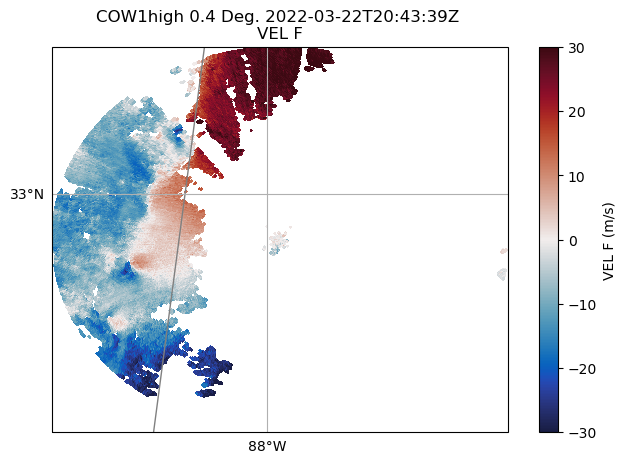

In [26]:
# Let us view the vleocity with the filter applied.
fig = plt.figure(figsize=[8, 5])
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map(
    "VEL_F",
    sweep=0,
    resolution="50m",
    projection=ccrs.PlateCarree(),
    cmap="pyart_balance",
    vmin = -30, vmax = 30,
    gatefilter=gatefilter,)
plt.show()

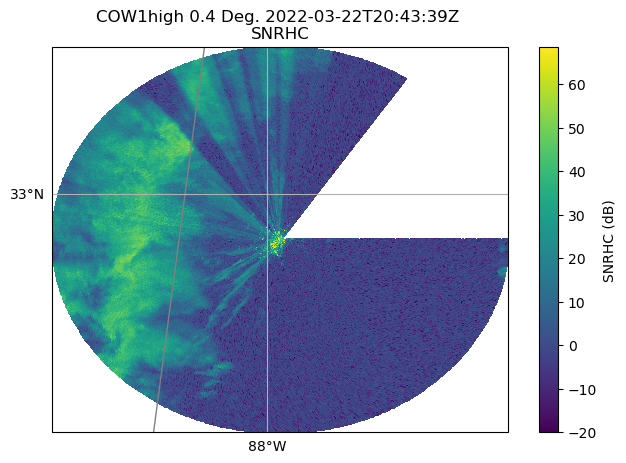

In [258]:
# Let us view the vleocity with the filter applied.
fig = plt.figure(figsize=[8, 5])
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map(
    "SNRHC",
    sweep=0,
    resolution="50m",
    projection=ccrs.PlateCarree(),)
plt.show()

In [27]:
gf = pyart.filters.GateFilter(radar)
gf.exclude_invalid("DBZHCC_F")
gf.exclude_outside("DBZHCC_F", -30, 100)
gf.exclude_below("SNRHC", 10)
gf.exclude_above('VT', 10) # Value found by trial and error for this case

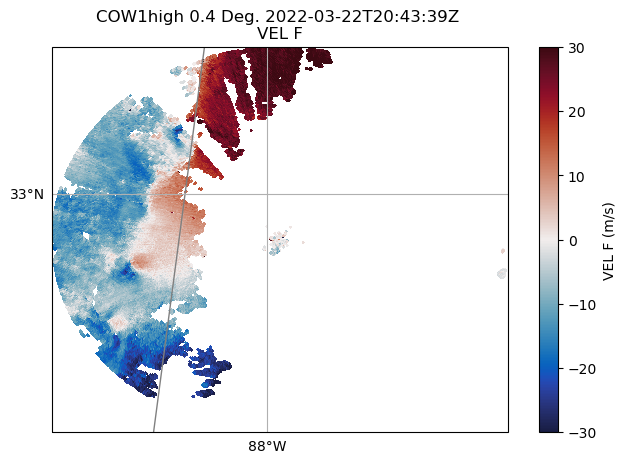

In [28]:
# Let us view the vleocity with the filter applied.
fig = plt.figure(figsize=[8, 5])
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map(
    "VEL_F",
    sweep=0,
    resolution="50m",
    projection=ccrs.PlateCarree(),
    cmap="pyart_balance",
    vmin = -30, vmax = 30,
    gatefilter=gf,)
plt.show()

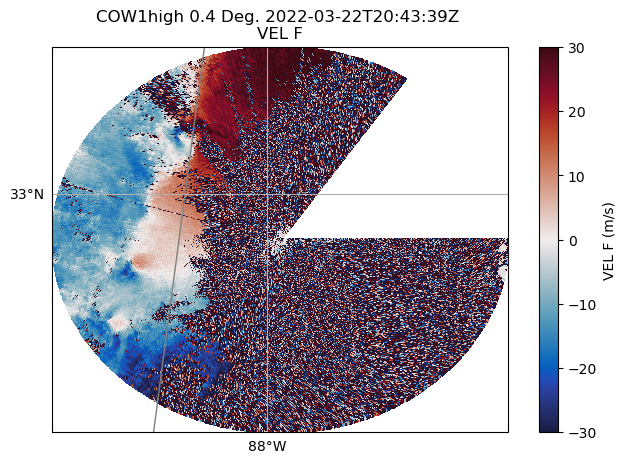

In [141]:
# Let us view the vleocity with the filter applied.
fig = plt.figure(figsize=[8, 5])
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map(
    "VEL_F",
    sweep=0,
    resolution="50m",
    projection=ccrs.PlateCarree(),
    cmap="pyart_balance",
    vmin = -30, vmax = 30,)
plt.show()

In [186]:
wind_size = 3
from pyart.util import angular_texture_2d
nyq = [radar.get_nyquist_vel(i, False) for i in range(radar.nsweeps)]
for i in range(0, radar.nsweeps):
    start_ray, end_ray = radar.get_start_end(i)
    inds = range(start_ray, end_ray)
    vel_sweep = radar.fields["VEL_F"]["data"][inds]
    vel_texture[inds] = angular_texture_2d(vel_sweep, wind_size, nyq[i])

In [190]:
radar.get_start()

range(4320, 5039)

In [162]:
vel_texture[inds]

array([[24.29598368, 24.81453986, 25.27131217, ..., 15.76949062,
        31.39502953, 25.22005243],
       [22.77158299, 38.5578698 , 33.56889199, ..., 27.5055677 ,
        24.2449513 , 18.37824352],
       [10.70759759, 26.31021856, 42.41470841, ..., 15.60594894,
        10.17485202,  9.9852503 ],
       ...,
       [33.34258997, 31.21026413, 23.73093962, ...,  0.96449931,
         0.74618134,  0.70210624],
       [27.0637031 , 29.75943892, 30.44128848, ...,  1.52097593,
         0.92014319,  0.88277783],
       [33.01099627, 30.52854645, 19.6327901 , ...,  1.76802935,
         1.03188594,  0.93654044]])

Text(0, 0.5, 'Count')

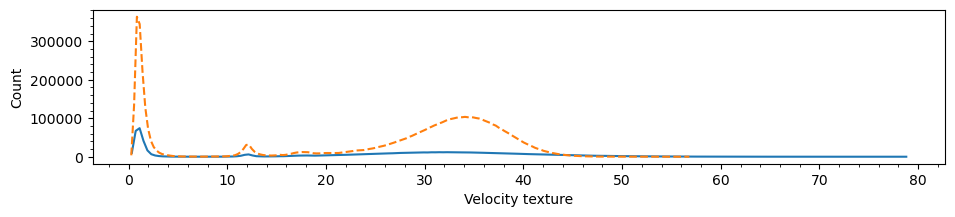

In [171]:
hist1, bins1 = np.histogram(vel_texture[inds], bins=200)
bins1 = (bins1[1:] + bins1[:-1]) / 2.0
plt.figure(figsize = [11, 2])
plt.plot(bins1, hist1)
plt.plot(bins, hist, "--")
plt.minorticks_on()
plt.xlabel("Velocity texture")
plt.ylabel("Count")

In [174]:
radar.nrays

5040

In [175]:
radar.ngates

1180

In [29]:
for file in cow1_files[111:112]:
    radar = pyart.io.read(file)
    radar = filter_radar(radar)
    dealiase(radar, 'VEL_F')
#     pathlib.Path(f"{out_dir}{os.sep}{radar_type[0]}{os.sep}QCed{os.sep}").mkdir(parents=True, exist_ok=True)
#     pyart.io.write_cfradial(filename=f"{out_dir}{os.sep}{radar_type[0]}{os.sep}QCed{os.sep}{file.split(os.sep)[-1]}", radar=radar,)
#     print(file.split(os.sep)[-1])
#     print(f"{out_dir}{os.sep}{radar_type[0]}{os.sep}QCed{os.sep}{file.split(os.sep)[-1]}")

TypeError: unhashable type: 'MaskedConstant'

In [56]:
ls "{out_dir}{os.sep}{radar_type[0]}{os.sep}QCed{os.sep}"

cfrad.20220322_204339.897_to_20220322_204507.832_COW1high_SUR.nc
cfrad.20220322_204507.847_to_20220322_204637.888_COW1high_SUR.nc


In [59]:
for file in dow7_files[110:112]:
    radar = pyart.io.read(file)
    radar = filter_radar(radar)
    dealiase(radar, 'VEL_F')
    pathlib.Path(f"{out_dir}{os.sep}{radar_type[1]}{os.sep}QCed{os.sep}").mkdir(parents=True, exist_ok=True)
    pyart.io.write_cfradial(filename=f"{out_dir}{os.sep}{radar_type[1]}{os.sep}QCed{os.sep}{file.split(os.sep)[-1]}", radar=radar,)
    print(file.split(os.sep)[-1])
    print(f"{out_dir}{os.sep}{radar_type[1]}{os.sep}QCed{os.sep}{file.split(os.sep)[-1]}")

cfrad.20220322_214518.230_to_20220322_214713.257_DOW7high_SUR.nc
/depot/dawson29/data/Projects/PERiLS/obsdata/2022/Illinois_Mobile_Radar/IOP1//DOW7/QCed/cfrad.20220322_214518.230_to_20220322_214713.257_DOW7high_SUR.nc
cfrad.20220322_214713.273_to_20220322_214856.738_DOW7high_SUR.nc
/depot/dawson29/data/Projects/PERiLS/obsdata/2022/Illinois_Mobile_Radar/IOP1//DOW7/QCed/cfrad.20220322_214713.273_to_20220322_214856.738_DOW7high_SUR.nc


In [66]:
radar.fields.keys()

dict_keys(['NCP', 'TRIP_FLA', 'SNRHC', 'DBZHC', 'DBZHC_F', 'VEL_F', 'WIDTH', 'DBZHCC_F', 'VT', 'DBZH'])

In [65]:
for file in dow8_files[110:112]:
    radar = pyart.io.read(file)
    radar.scan_type = 'ppi'
    radar = filter_radar(radar)
    dealiase(radar, 'VEL_F')
    pathlib.Path(f"{out_dir}{os.sep}{radar_type[2]}{os.sep}QCed{os.sep}").mkdir(parents=True, exist_ok=True)
    pyart.io.write_cfradial(filename=f"{out_dir}{os.sep}{radar_type[2]}{os.sep}QCed{os.sep}{file.split(os.sep)[-1]}", radar=radar,)
    print(file.split(os.sep)[-1])
    print(f"{out_dir}{os.sep}{radar_type[2]}{os.sep}QCed{os.sep}{file.split(os.sep)[-1]}")

cfrad.20220322_203943.764_to_20220322_204001.720_DOW8_SUR.nc
/depot/dawson29/data/Projects/PERiLS/obsdata/2022/Illinois_Mobile_Radar/IOP1//DOW8/QCed/cfrad.20220322_203943.764_to_20220322_204001.720_DOW8_SUR.nc
cfrad.20220322_204001.730_to_20220322_204019.420_DOW8_SUR.nc
/depot/dawson29/data/Projects/PERiLS/obsdata/2022/Illinois_Mobile_Radar/IOP1//DOW8/QCed/cfrad.20220322_204001.730_to_20220322_204019.420_DOW8_SUR.nc


In [17]:
for file in cow1_files[0:1]:
    radar = pyart.io.read(file)

In [63]:
def align_radar_coords(radar):
    lons, lon_counts = np.unique(radar.longitude['data'], return_counts = True)
    c_lon = lons[np.argmax(lon_counts)]
    radar.longitude['data'] = np.array([c_lon])
    lats, lat_counts = np.unique(radar.latitude['data'], return_counts = True)
    c_lat = lats[np.argmax(lat_counts)]
    radar.latitude['data'] = np.array([c_lat])
    alts, alt_counts = np.unique(radar.altitude['data'], return_counts = True)
    c_alt = alts[np.argmax(alt_counts)]
    radar.altitude['data'] = np.array([c_alt])
    alts_agl, alt_agl_counts = np.unique(radar.altitude_agl['data'], return_counts = True)
    c_alt_agl = alts_agl[np.argmax(alt_agl_counts)]
    radar.altitude_agl['data'] = np.array([c_alt_agl])
    return radar

In [66]:
def align_coords(radar):
    attributes = ['longitude', 'latitude', 'altitude', 'altitude_agl']
    for attr_name in attributes:
        if not hasattr(radar, attr_name):
            print(f"attribute {attr_name} not present in the radar object")
            continue
        attr_data = getattr(radar, attr_name)
        if isinstance(attr_data, np.ma.core.MaskedArray):
            attr_data = np.ma.compressed(attr_data)
        unique_values, counts = np.unique(attr_data, return_counts=True)
        c_value = unique_values[np.argmax(counts)]
        setattr(radar, attr_name, c_value)
    print("Applied")
    return radar

In [67]:
for file in cow1_files[0:1]:
    radar = pyart.io.read(file)

In [68]:
radar = align_radar_coords(radar)

In [69]:
radar.altitude_agl['data']

array([nan])

In [70]:
pyart.io.write_cfradial("test.nc", radar=radar)

In [62]:
ls

1a_initial_data_processing.ipynb              quality_check_script.py
1a_merge_individial_sweeps_radx_trail2.ipynb  test.nc
Data_Quality_Check.ipynb                      Untitled1.ipynb
farm_iop1_qc.out                              verify_QC.ipynb
farm_iop1_qc.sbatch                           verify_qc.py
merge_individial_sweeps_radx.ipynb


In [16]:
radar.altitude_agl['data']

array([nan])

In [13]:
radar = filter_radar(radar)

TypeError: unhashable type: 'MaskedConstant'

In [ ]:
display = pyart.graph.RadarDisplay(radar)

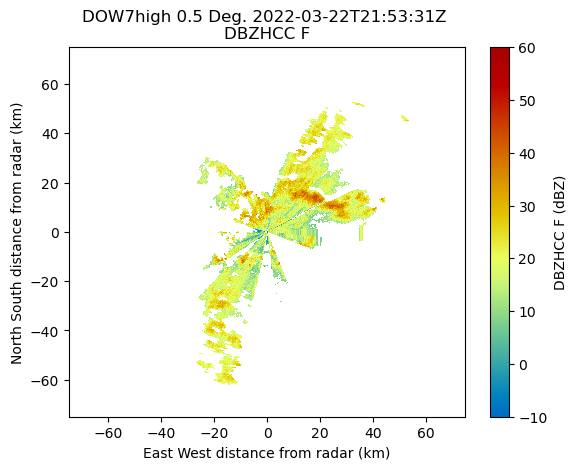

In [108]:
display.plot("DBZH", 0, vmin = -10, vmax = 60)

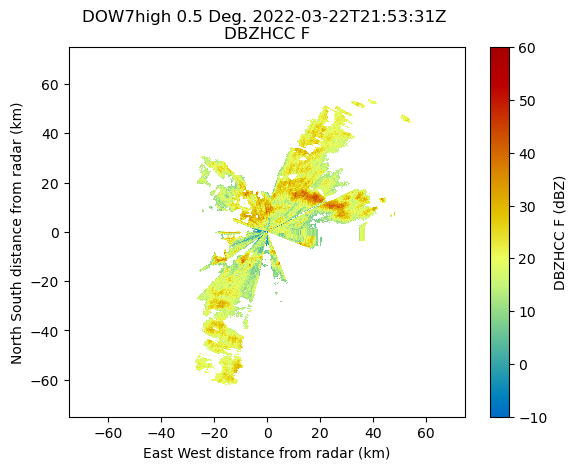

In [114]:
display.plot("DBZH", 0, vmin = -10, vmax = 60)

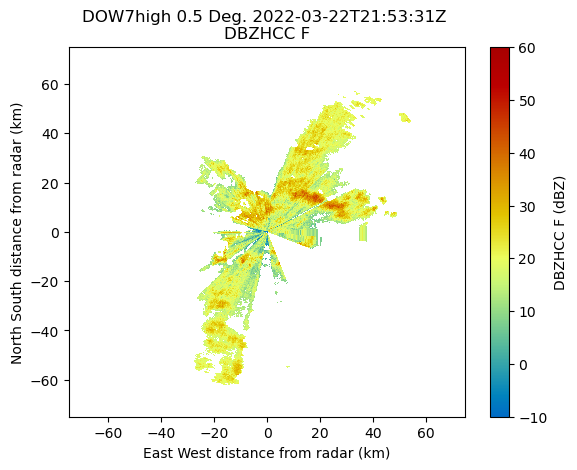

In [119]:
display.plot("DBZH", 0, vmin = -10, vmax = 60)

In [109]:
radar.longitude['data'], radar.latitude['data'], radar.altitude['data']

(array([-88.17179108]), array([32.71085739]), array([52.99999937]))

In [23]:
import numpy as np
import pyart

def align_coords(radar, attr_name):
    if type(radar) != pyart.core.Radar:
        print("The passed object is not of type Py-ART radar")
        return
    if not hasattr(radar, attr_name):
        print(f"Attribute {attr_name} not present in the radar object")
        return
    attr_data = getattr(radar, attr_name)
    if isinstance(attr_data, np.ma.core.MaskedArray):
        attr_data = np.ma.compressed(attr_data)
    unique_values, counts = np.unique(attr_data, return_counts=True)
    c_value = unique_values[np.argmax(counts)]
    setattr(radar, attr_name, np.array([c_value]))
    return c_value

In [39]:
radar1 = align_coords(radar)

In [27]:
radar.latitude

array([{'long_name': 'latitude', 'units': 'degrees_north', '_FillValue': -9999.0, 'data': masked_array(data=[32.810977935791016, 32.810977935791016,
                          32.810977935791016, ..., --, --, --],
                    mask=[False, False, False, ...,  True,  True,  True],
              fill_value=-9999.0)}                                                                                                                  ],
      dtype=object)

In [43]:
radar1.altitude

{'long_name': 'altitude',
 'units': 'meters',
 '_FillValue': -9999.0,
 'positive': 'up',
 'data': array([57.99999833])}